In [1]:
from keras.layers import *
from keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np
import cv2


In [2]:
def unet(pretrained_weights = None,input_size = (512,512,1)):
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = Model(inputs,conv10)

    model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])
    

    if(pretrained_weights):
      model.load_weights(pretrained_weights)

    return model


In [5]:
model=unet()
model.load_weights('weights00000005.h5')


line_img_array=[]

In [6]:
def segment_into_lines(filename):
    
    img=cv2.imread(f'{filename}',0)
    ret,img=cv2.threshold(img,150,255,cv2.THRESH_BINARY_INV)
    img=cv2.resize(img,(512,512))
   
    img= np.expand_dims(img,axis=-1)

    img=np.expand_dims(img,axis=0)
    pred=model.predict(img)
    pred=np.squeeze(np.squeeze(pred,axis=0),axis=-1)

    

    coordinates=[]
    img = cv2.normalize(src=pred, dst=None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC1)
    cv2.threshold(img,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU,img)
    ori_img=cv2.imread(f'{filename}',0)
 

    (H, W) = ori_img.shape[:2]
    (newW, newH) = (512, 512)
    rW = W / float(newW)
    rH = H / float(newH)
    
    contours, hier = cv2.findContours(img, cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE)
    for c in contours:
        # get the bounding rect
        x, y, w, h = cv2.boundingRect(c)
        #cv2.rectangle(ori_img, (int(x*rW), int(y*rH)), (int((x+w)*rW),int((y+h)*rH)), (255,0,0), 1)
        coordinates.append((int(x*rW),int(y*rH),int((x+w)*rW),int((y+h)*rH)))
    #cv2.imwrite("output.jpg",ori_img)

    for i in range(len(coordinates)-1,-1,-1):
        coors=coordinates[i]

        p_img=ori_img[coors[1]:coors[3],coors[0]:coors[2]].copy()

        line_img_array.append(p_img)

    return line_img_array

In [7]:
result=segment_into_lines("test_img.jpg")

2022-06-19 09:41:24.231879: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8401
2022-06-19 09:41:25.884082: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


In [8]:
result[0].shape

(50, 990)

In [9]:
print(result[0][:,:,np.newaxis].shape)

(50, 990, 1)


In [10]:
#print(result[0][np.newaxis].shape)

In [11]:
x=result[0][:,:,np.newaxis].shape

In [12]:
#cv2.imshow("image",x)

In [13]:
img=cv2.imread(f'test_img.jpg',0)

In [14]:
img.shape

(1853, 1196)

In [15]:
#cv2.imshow("image",img)

In [16]:
#cv2.imshow("image", img)
#cv2.waitKey(0)

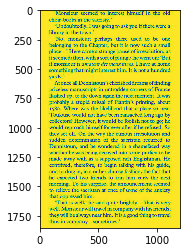

In [17]:
from matplotlib import pyplot as plt
plt.imshow(img, interpolation='nearest')
plt.show()

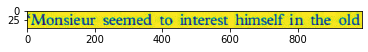

In [18]:
plt.imshow(result[0], interpolation='nearest')
#plt.imshow(result[1], interpolation='nearest')
plt.show()